In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
def ReadSplitDataFile(file_name):
  subject = {"segments": [], "segment_lengths": [], "id": -1, "Age": -1, "Height(cm)": -1, "Weight(kg)": -1, "Hemoglobin(g/L)": -1, "Gender": -1}
  with open(file_name) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    k = 0

    red1 = []
    red2 = []
    ir1 = []
    ir2 = []
    lengths = []
    for row in csv_reader:
      if k == 1:
        subject["id"] = int(row[5])
        subject["Age"] = int(row[6])
        subject["Height(cm)"] = float(row[7])
        subject["Weight(kg)"] = float(row[8])
        subject["Hemoglobin(g/L)"] = float(row[9])

        if row[10] == "male":
          subject["Gender"] = 1
        else:
          subject["Gender"] = 0

      if k > 0:
        red1.append(float(row[0]))
        red2.append(float(row[1]))
        ir1.append(float(row[2]))
        ir2.append(float(row[3]))
        lengths.append(float(row[4]))

        if len(red1) == 100:
          subject["segments"].append([red1, red2, ir1, ir2])
          subject["segment_lengths"].append(sum(lengths) / len(lengths))
          red1 = []
          red2 = []
          ir1 = []
          ir2 = []
          lengths = []
      k += 1

# rationalize and preprocess //normalize and embed using pytorch embedding -> focus on the centeral question and which part of the signals is important(?) interpertable
# 1D CNN with 4 channels
# End use?
# advanced architecture, less features selections ?
# ????? keep the kernel small (GX BOOST)


  subject["segments"] = np.array(subject["segments"])
  return subject

In [ ]:
subject = ReadSplitDataFile("data/1.csv")

In [ ]:
subjects = []
for i in range(1, 59):
  subjects.append(ReadSplitDataFile("data/" + str(i) + ".csv"))

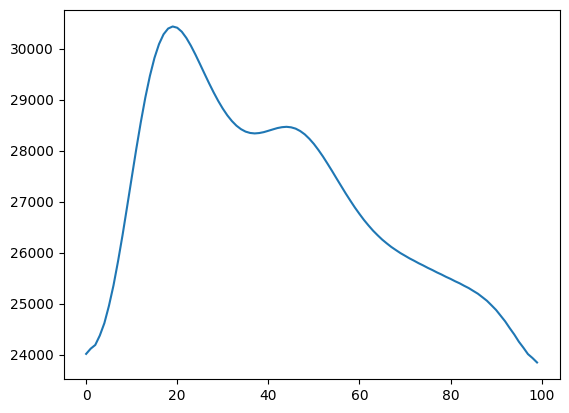

In [ ]:
plt.plot(subjects[29]["segments"][1][3])
plt.show()

In [ ]:
shuffled_subjects = subjects.copy()
random.seed(41)
random.shuffle(shuffled_subjects)
split = int(0.8*len(shuffled_subjects))
training_split, test_split = shuffled_subjects[:split], shuffled_subjects[split:len(shuffled_subjects)]

In [ ]:
training_data = []

for subject in training_split:
  for i in range(len(subject["segments"])):
    segment_data = {}
    segment_data["segment"] = subject["segments"][i]
    segment_data["id"] = subject["id"]
    segment_data["Age"] = subject["Age"]
    segment_data["Height(cm)"] = subject["Height(cm)"]
    segment_data["Weight(kg)"] = subject["Weight(kg)"]
    segment_data["Hemoglobin(g/L)"] = subject["Hemoglobin(g/L)"]
    segment_data["Gender"] = subject["Gender"]
    segment_data["length"] = subject["segment_lengths"][i]
    training_data.append(segment_data)

random.shuffle(training_data)

In [ ]:
test_data = []

for subject in test_split:
  for i in range(len(subject["segments"])):
    segment_data = {}
    segment_data["segment"] = subject["segments"][i]
    segment_data["id"] = subject["id"]
    segment_data["Age"] = subject["Age"]
    segment_data["Height(cm)"] = subject["Height(cm)"]
    segment_data["Weight(kg)"] = subject["Weight(kg)"]
    segment_data["Hemoglobin(g/L)"] = subject["Hemoglobin(g/L)"]
    segment_data["Gender"] = subject["Gender"]
    segment_data["length"] = subject["segment_lengths"][i]
    test_data.append(segment_data)

random.shuffle(test_data)

In [ ]:
print(len(training_data))
print(len(test_data))

3506
982


In [ ]:
train_segments = []
train_meta_data = []
train_targets = []
for segment in training_data:
  train_segments.append(segment["segment"])
  train_targets.append(segment["Hemoglobin(g/L)"])
  train_meta_data.append([segment["Age"], segment["Height(cm)"], segment["Weight(kg)"], segment["Gender"], segment["length"]])

train_segments = np.array(train_segments)
train_targets = np.array(train_targets)
train_meta_data = np.array(train_meta_data)

In [ ]:
train_targets = train_targets.reshape(len(train_targets), 1)
print("Target shape:", train_targets.shape)

print("Segment shape:", train_segments.shape)
print("Meta data shape:", train_meta_data.shape)

Target shape: (3506, 1)
Segment shape: (3506, 4, 100)
Meta data shape: (3506, 5)


In [ ]:
class RegressionCNN(nn.Module):
  def __init__(self, meta_data_size=5):
    super(RegressionCNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = 1, padding = 1)
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(64 * 1 * 25 + meta_data_size, 128)
    self.fc2 = nn.Linear(128, 1)


  def forward(self, x, meta_data):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)

    x = self.flatten(x)

    x = torch.cat((x, meta_data), dim=1)

    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)

    return x


In [ ]:
model = RegressionCNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
num_epochs = 75
batch_size = 16

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0.0

  for k in range(0, len(train_segments), batch_size):
    batch_data = train_segments[k:k+batch_size]
    batch_targets = train_targets[k:k+batch_size]
    batch_data = torch.tensor(batch_data, dtype = torch.float32).unsqueeze(1)
    batch_meta_data = torch.tensor(train_meta_data[k:k+batch_size], dtype = torch.float32)
    batch_targets = torch.tensor(batch_targets, dtype = torch.float32)

    optimizer.zero_grad()
    outputs = model(batch_data, batch_meta_data)
    loss = criterion(outputs, batch_targets)
    epoch_loss += loss.item() * batch_data.size(0)
    loss.backward()
    optimizer.step()

  avg_epoch_loss = epoch_loss / len(train_segments)
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')


Epoch [1/75], Loss: 104.5544
Epoch [2/75], Loss: 102.4960
Epoch [3/75], Loss: 100.5915
Epoch [4/75], Loss: 99.0639
Epoch [5/75], Loss: 97.8235
Epoch [6/75], Loss: 96.6986
Epoch [7/75], Loss: 95.7066
Epoch [8/75], Loss: 94.8178
Epoch [9/75], Loss: 94.0350
Epoch [10/75], Loss: 93.3276
Epoch [11/75], Loss: 92.6095
Epoch [12/75], Loss: 91.9893
Epoch [13/75], Loss: 91.4903
Epoch [14/75], Loss: 91.0223
Epoch [15/75], Loss: 90.6116
Epoch [16/75], Loss: 90.2094
Epoch [17/75], Loss: 89.9004
Epoch [18/75], Loss: 89.6404
Epoch [19/75], Loss: 89.3347
Epoch [20/75], Loss: 89.0951
Epoch [21/75], Loss: 88.8741
Epoch [22/75], Loss: 88.7041
Epoch [23/75], Loss: 88.5336
Epoch [24/75], Loss: 88.4167
Epoch [25/75], Loss: 88.2735
Epoch [26/75], Loss: 88.1383
Epoch [27/75], Loss: 88.0193
Epoch [28/75], Loss: 87.8882
Epoch [29/75], Loss: 87.7839
Epoch [30/75], Loss: 87.6875
Epoch [31/75], Loss: 87.5904
Epoch [32/75], Loss: 87.5009
Epoch [33/75], Loss: 87.4211
Epoch [34/75], Loss: 87.3378
Epoch [35/75], Loss:

In [ ]:
test_segments = []
test_targets = []
test_meta_data = []
for segment in test_data:
  test_segments.append(segment["segment"])
  test_targets.append(segment["Hemoglobin(g/L)"])
  test_meta_data.append([segment["Age"], segment["Height(cm)"], segment["Weight(kg)"], segment["Gender"], segment["length"]])


test_segments = np.array(test_segments)
test_targets = np.array(test_targets)
test_meta_data = np.array(test_meta_data)

test_targets = test_targets.reshape(len(test_targets), 1)
print("Test target shape:", test_targets.shape)

print("Test segment shape:", test_segments.shape)
print("Test meta data shape:", test_meta_data.shape)

Test target shape: (982, 1)
Test segment shape: (982, 4, 100)
Test meta data shape: (982, 5)


In [ ]:
test_segments = torch.tensor(test_segments, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32)
test_meta_data = torch.tensor(test_meta_data, dtype=torch.float32)

test_segments = test_segments.unsqueeze(1)

# Set the model to evaluation mode (turn off dropout, batchnorm, etc.)
model.eval()

# Perform inference (no gradient calculation needed)
with torch.no_grad():  # No need to track gradients during evaluation
    predictions = model(test_segments, test_meta_data)  # Model output (predicted values)
    loss = criterion(predictions, test_targets)  # Calculate loss (MSE in this case

# Convert the predictions and targets to numpy arrays for R^2 calculation
predictions_np = predictions.numpy().flatten()  # Flatten to 1D array
targets_np = test_targets.numpy().flatten()  # Flatten to 1D array

In [ ]:
print(loss)
print(r2_score(targets_np, predictions_np))

tensor(38.2918)
0.8181158900260925


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(targets_np, predictions_np)
print("MAE:", mae)


MAE: 5.353616237640381


<ipython-input-40-284b45d2d5cb>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


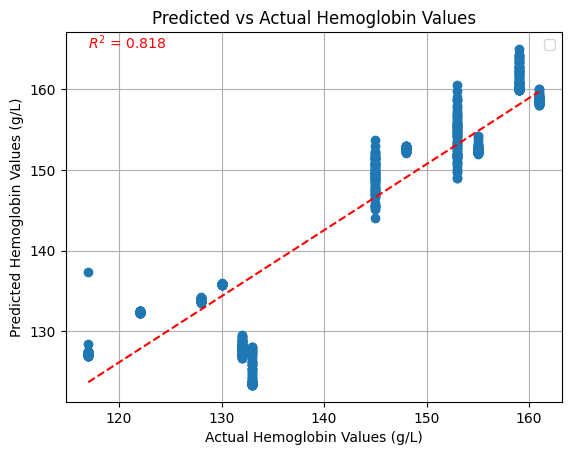

In [ ]:
# Fit a line: y = m*x + b
m, b = np.polyfit(targets_np, predictions_np, 1)
x = np.array([min(targets_np), max(targets_np)])
line = m * x + b

# Calculate R^2
r2 = r2_score(targets_np, predictions_np)

# Plot
plt.plot(targets_np, predictions_np, 'o')
plt.plot(x, line, 'r--')
plt.text(min(targets_np), max(predictions_np), f'$R^2$ = {r2:.3f}', fontsize=10, color='red')

plt.xlabel("Actual Hemoglobin Values (g/L)")
plt.ylabel("Predicted Hemoglobin Values (g/L)")
plt.title("Predicted vs Actual Hemoglobin Values")
plt.legend()
plt.grid(True)
plt.show()

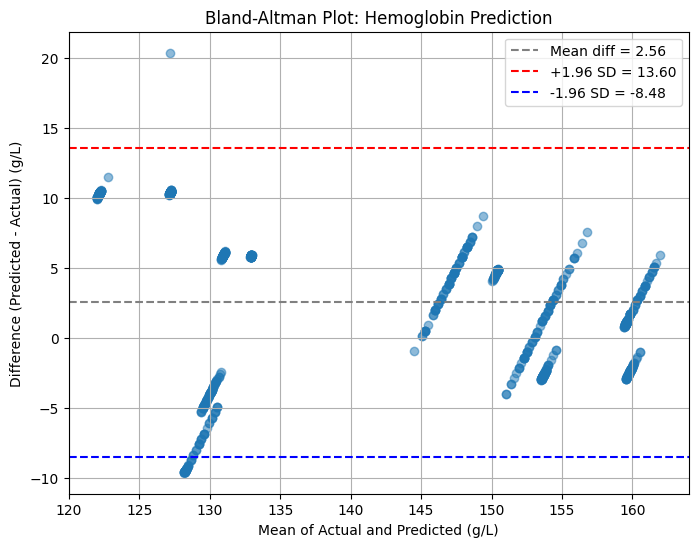

In [ ]:
# Calculate the average and difference
avg = (predictions_np + targets_np) / 2
diff = predictions_np - targets_np  # Difference between predicted and actual
mean_diff = np.mean(diff)
std_diff = np.std(diff)

# Limits of agreement
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(avg, diff, alpha=0.5)
plt.axhline(mean_diff, color='gray', linestyle='--', label=f'Mean diff = {mean_diff:.2f}')
plt.axhline(loa_upper, color='red', linestyle='--', label=f'+1.96 SD = {loa_upper:.2f}')
plt.axhline(loa_lower, color='blue', linestyle='--', label=f'-1.96 SD = {loa_lower:.2f}')

plt.xlabel('Mean of Actual and Predicted (g/L)')
plt.ylabel('Difference (Predicted - Actual) (g/L)')
plt.title('Bland-Altman Plot: Hemoglobin Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
printed_vals = []
for val in targets_np:
  if val not in printed_vals:
    printed_vals.append(val)
    print(val)

120.0
144.0
121.0
152.0
128.0
130.0
169.0
154.0
164.0
155.0
157.0


In [ ]:
print(predictions_np)

[101.933525  87.41567  169.81857  118.138695 191.4277   119.182526
 138.15005  185.30066  107.19416  185.09705   86.13876  120.310875
 128.01788  285.57947   96.83604  155.32379  152.40146  121.0017
 124.25556  126.006966 189.05649  223.89304  104.488335 123.71291
 152.05371  276.73837  151.10663  170.00392  104.83474  120.11901
  86.24932  289.32462  122.62064  122.78719  129.38666  140.46687
 276.5175   161.78616  108.20559  122.65006  181.42368  278.9539
 253.09814  132.5451    86.36058  160.65903  105.478325 144.31525
 140.36877  132.25285  111.824615 113.90966  119.53109  109.57334
  94.72149  265.34622  116.2564   122.61263  173.28491  110.73529
 261.87177  153.50421  118.34615  132.40927  144.4628   145.40808
  89.12655  153.43185   96.86874   89.36971  115.49903  279.65247
  94.24804   96.04331  140.69403  216.36075  139.65598  286.09814
 173.59166  119.8953   139.55357  257.39246   86.77727  142.1323
  94.08718  149.50172  147.13147  124.48063  112.38916  103.85522
 109.144066